# Arbitrage

This Jupyter Notebook demonstrates a mean reversion strategy in the context of pairs trading, a popular strategy in quantitative trading. Pairs trading is based on the assumption that highly correlated or cointegrated stock pairs tend to revert to a mean over time. This is often described by the concept of "one asset one price," where price differences between the two stocks are considered short-term anomalies that will equalize in the long term.

In this analysis, we focus on two UBS stocks. One is traded in Swiss Francs, the other in USD. According to the one asset one price concept, the price should be the same. The price difference between these stocks is used as a signal for trading decisions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
db_name = os.getenv("db_name")
db_user = os.getenv("db_user")
db_password = os.getenv("db_password")
db_host = os.getenv("db_host")

engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}/{db_name}')

## Loading and preparation of data

I use the data that is stored in the database. Because the prices for stocks and currencies are stored in different tables, I use a left join to add the currency prices to the stock prices. The data is then prepared to be used in a Pandas df.

In [3]:
query = """SELECT StockPrice.Ticker, StockPrice.Date, StockPrice.Open, StockPrice.Close AS Close, CurrencyPrice.Close AS CurrencyClose
    FROM StockPrice LEFT JOIN CurrencyPrice ON CurrencyPrice.Date = StockPrice.Date
    AND CurrencyPrice.Ticker = 'CHF=X' WHERE StockPrice.Ticker IN ('UBSG.SW', 'UBS');"""

df = pd.read_sql(query, engine)

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.head()

,ticker,date,open,close,currencyclose
0,UBSG.SW,2019-07-12,9.29,9.30,0.99050
1,UBSG.SW,2019-07-15,9.24,9.24,0.98400
2,UBSG.SW,2019-07-16,9.24,9.33,0.98410
3,UBSG.SW,2019-07-17,9.28,9.28,0.98799
4,UBSG.SW,2019-07-18,9.20,9.22,0.98660


In [5]:
df.melt(id_vars=['date', 'ticker', 'currencyclose'], var_name='metric', value_name='value')

,date,ticker,currencyclose,metric,value
0,2019-07-12,UBSG.SW,0.99050,open,9.29
1,2019-07-15,UBSG.SW,0.98400,open,9.24
2,2019-07-16,UBSG.SW,0.98410,open,9.24
3,2019-07-17,UBSG.SW,0.98799,open,9.28
4,2019-07-18,UBSG.SW,0.98660,open,9.20
...,...,...,...,...,...
5037,2024-07-08,UBS,0.89523,close,30.39
5038,2024-07-09,UBS,0.89781,close,30.27
5039,2024-07-10,UBS,0.89740,close,30.74
5040,2024-07-11,UBS,0.89920,close,31.03


In [6]:
df_melted = df.melt(id_vars=['date', 'ticker', 'currencyclose'], var_name='metric', value_name='value')
df_pivot = df_melted.pivot_table(index='date', columns=['ticker', 'metric'], values='value')
df_pivot['Currency', 'close'] = df.groupby('date')['currencyclose'].first()
df_pivot

ticker        UBS        UBSG.SW        Currency
metric      close   open   close   open    close
date                                            
2019-07-12  10.37  10.35    9.30   9.29  0.99050
2019-07-15  10.31  10.27    9.24   9.24  0.98400
2019-07-16  10.27  10.34    9.33   9.24  0.98410
2019-07-17  10.21  10.32    9.28   9.28  0.98799
2019-07-18  10.29  10.22    9.22   9.20  0.98660
...           ...    ...     ...    ...      ...
2024-07-08  30.39  30.63   27.31  26.95  0.89523
2024-07-09  30.27  30.15   27.11  27.10  0.89781
2024-07-10  30.74  30.43   27.55  27.29  0.89740
2024-07-11  31.03  31.01   27.74  27.66  0.89920
2024-07-12  31.26  31.24   27.96  27.87  0.89485

[1291 rows x 5 columns]

In the next step I recalculate the CHF open and close prices to USD, according to the current FX price.

In [7]:
df_pivot['UBSG.SW', 'USD_close'] = df_pivot['UBSG.SW', 'close'] / df_pivot['Currency', 'close']
df_pivot['UBSG.SW', 'USD_open'] = df_pivot['UBSG.SW', 'open'] / df_pivot['Currency', 'close']

df_pivot.head()

ticker        UBS        UBSG.SW       Currency   UBSG.SW          
metric      close   open   close  open    close USD_close  USD_open
date                                                               
2019-07-12  10.37  10.35    9.30  9.29  0.99050  9.389197  9.379101
2019-07-15  10.31  10.27    9.24  9.24  0.98400  9.390244  9.390244
2019-07-16  10.27  10.34    9.33  9.24  0.98410  9.480744  9.389290
2019-07-17  10.21  10.32    9.28  9.28  0.98799  9.392808  9.392808
2019-07-18  10.29  10.22    9.22  9.20  0.98660  9.345226  9.324954

Different trading venues mean different trading holidays and therefore missing data. Pandas offers easy technics to detect and correct these. I use the fill forward method to override missing values. That means, that the last day data is used.

In [8]:
df_pivot.isna().sum()

ticker    metric   
UBS       close        32
          open         32
UBSG.SW   close        29
          open         29
Currency  close         1
UBSG.SW   USD_close    30
          USD_open     30
dtype: int64

In [9]:
df_pivot = df_pivot.ffill()
df_pivot.isna().sum()

ticker    metric   
UBS       close        0
          open         0
UBSG.SW   close        0
          open         0
Currency  close        0
UBSG.SW   USD_close    0
          USD_open     0
dtype: int64

In [10]:
df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]
df_pivot

,UBS_close,UBS_open,UBSG.SW_close,UBSG.SW_open,Currency_close,UBSG.SW_USD_close,UBSG.SW_USD_open
date,,,,,,,
2019-07-12,10.37,10.35,9.30,9.29,0.99050,9.389197,9.379101
2019-07-15,10.31,10.27,9.24,9.24,0.98400,9.390244,9.390244
2019-07-16,10.27,10.34,9.33,9.24,0.98410,9.480744,9.389290
2019-07-17,10.21,10.32,9.28,9.28,0.98799,9.392808,9.392808
2019-07-18,10.29,10.22,9.22,9.20,0.98660,9.345226,9.324954
...,...,...,...,...,...,...,...
2024-07-08,30.39,30.63,27.31,26.95,0.89523,30.506127,30.103996
2024-07-09,30.27,30.15,27.11,27.10,0.89781,30.195698,30.184560
2024-07-10,30.74,30.43,27.55,27.29,0.89740,30.699799,30.410074


## Plot same asset not always same price

The following plot show the prices of the USD stock and of the CHF stock converted to USD. Until mid 2020 there is a significant difference in the prices. After that, there are only small difference visible.

<Axes: xlabel='date'>

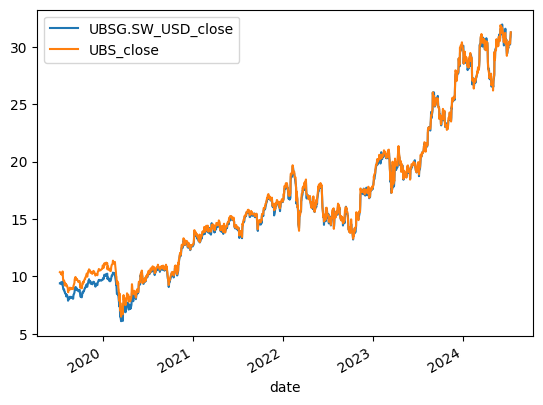

In [11]:
df_pivot[["UBSG.SW_USD_close", "UBS_close"]].plot()

Next I calculate the absolute and relative difference between the closings.

In [12]:
df_pivot["diff"] = df_pivot["UBSG.SW_USD_close"] - df_pivot["UBS_close"]
df_pivot["diff_perc"] = df_pivot["diff"] / df_pivot["UBS_close"]
df_pivot

,UBS_close,UBS_open,UBSG.SW_close,UBSG.SW_open,Currency_close,UBSG.SW_USD_close,UBSG.SW_USD_open,diff,diff_perc
date,,,,,,,,,
2019-07-12,10.37,10.35,9.30,9.29,0.99050,9.389197,9.379101,-0.980803,-0.094581
2019-07-15,10.31,10.27,9.24,9.24,0.98400,9.390244,9.390244,-0.919756,-0.089210
2019-07-16,10.27,10.34,9.33,9.24,0.98410,9.480744,9.389290,-0.789256,-0.076851
2019-07-17,10.21,10.32,9.28,9.28,0.98799,9.392808,9.392808,-0.817192,-0.080038
2019-07-18,10.29,10.22,9.22,9.20,0.98660,9.345226,9.324954,-0.944774,-0.091815
...,...,...,...,...,...,...,...,...,...
2024-07-08,30.39,30.63,27.31,26.95,0.89523,30.506127,30.103996,0.116127,0.003821
2024-07-09,30.27,30.15,27.11,27.10,0.89781,30.195698,30.184560,-0.074302,-0.002455
2024-07-10,30.74,30.43,27.55,27.29,0.89740,30.699799,30.410074,-0.040201,-0.001308


Plotting the differences confirms the findings from the previous plot. At the beginning, there is difference, that I cannot explain on the data available. But afterwards, the difference tends to have a mean of around zero. There are spike from -0.75 to 0.5, but tend to quickly reverse to the mean.

<Axes: xlabel='date'>

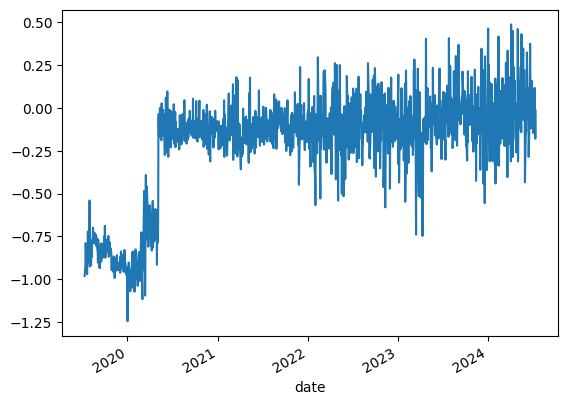

In [13]:
df_pivot["diff"].plot()

<Axes: xlabel='date'>

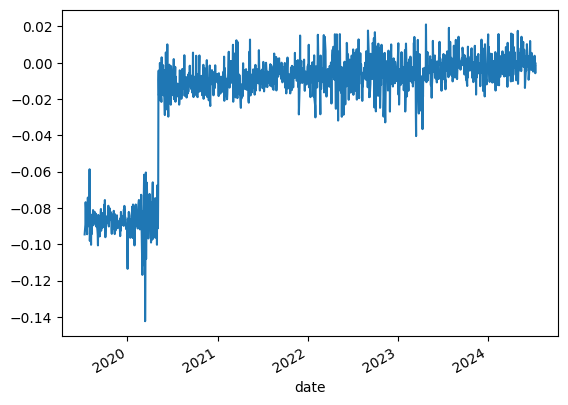

In [14]:
df_pivot["diff_perc"].plot()

Zooming in with a startdate SOY 2023 gives a detailed view of the differences. 

<Axes: xlabel='date'>

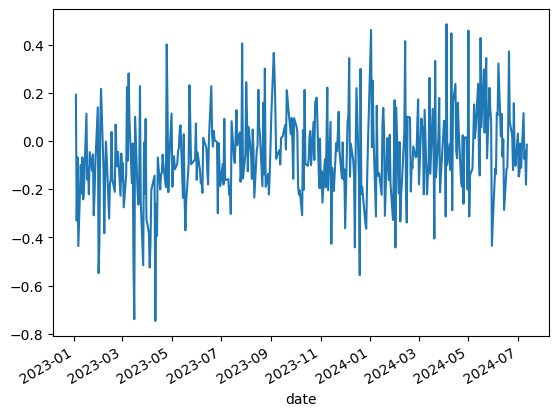

In [15]:
df_pivot.loc["2023-01-01":]["diff"].plot()

<Axes: xlabel='date'>

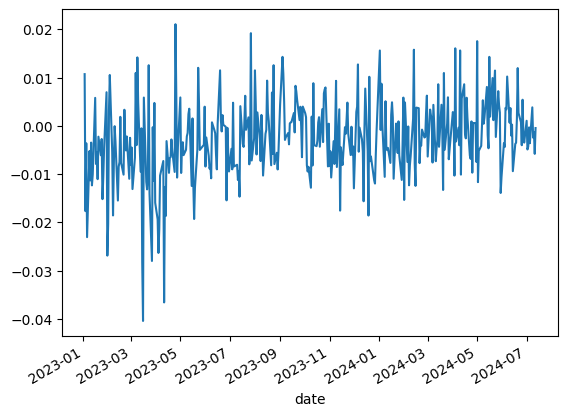

In [16]:
df_pivot.loc["2023-01-01":]["diff_perc"].plot()

As I don't know what causes the difference at the beginning of the timeseries, I decided to cut of these data. This allows to continue the example with coherent, as expected data.

In [17]:
df_filtered = df_pivot.loc["2021-01-01":]
df_filtered.head()

,UBS_close,UBS_open,UBSG.SW_close,UBSG.SW_open,Currency_close,UBSG.SW_USD_close,UBSG.SW_USD_open,diff,diff_perc
date,,,,,,,,,
2021-01-04,12.90,13.03,11.28,11.29,0.88310,12.773185,12.784509,-0.126815,-0.009831
2021-01-05,13.19,13.06,11.41,11.27,0.88124,12.947665,12.788798,-0.242335,-0.018373
2021-01-06,13.63,13.48,11.90,11.60,0.87818,13.550753,13.209137,-0.079247,-0.005814
2021-01-07,14.03,13.90,12.22,11.98,0.87807,13.916886,13.643559,-0.113114,-0.008062
2021-01-08,13.80,13.89,12.07,12.31,0.88515,13.636107,13.907247,-0.163893,-0.011876


<Axes: xlabel='date'>

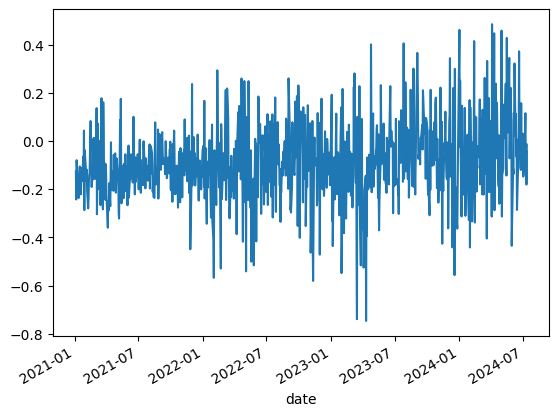

In [18]:
df_filtered["diff"].plot()

<Axes: xlabel='date'>

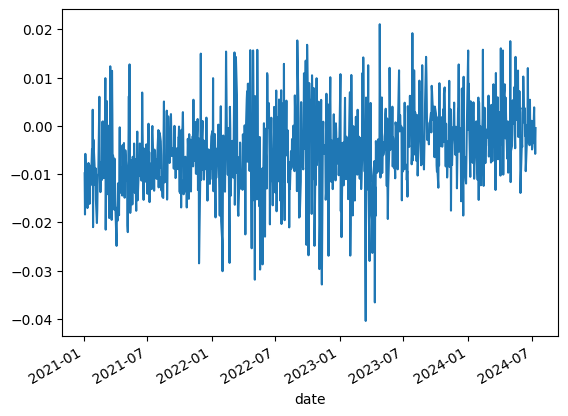

In [19]:
df_filtered["diff_perc"].plot()

The following histogram shows, that the differences are more or less normal distributed with a mean that below zero.

<Axes: >

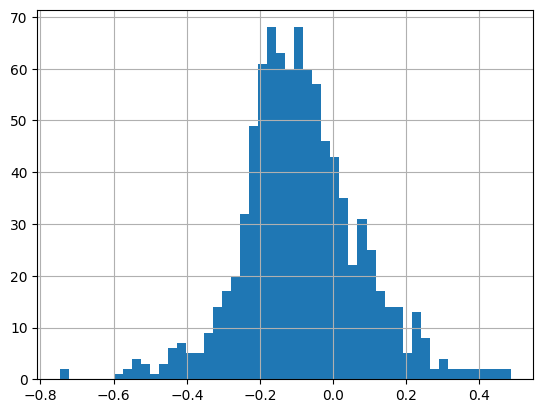

In [20]:
df_filtered["diff"].hist(bins=50)

<Axes: >

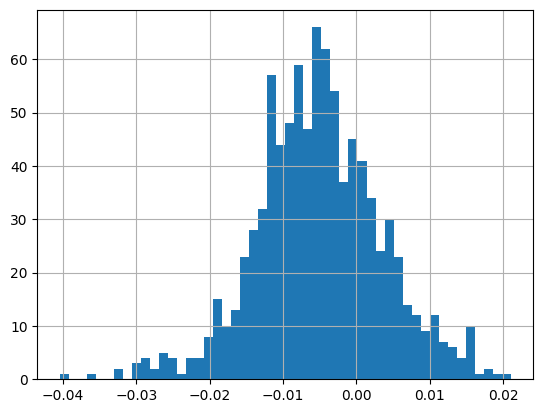

In [21]:
df_filtered["diff_perc"].hist(bins=50)

The following Pandas overview confirms a negative mean. One standard devation is 0.16 and half of the differences lay between -0.18 and 0.01.

In [22]:
df_filtered[["diff", "diff_perc"]].describe()

,diff,diff_perc
count,910.000000,910.000000
mean,-0.087410,-0.005144
std,0.163154,0.008636
min,-0.746924,-0.040434
25%,-0.184526,-0.010657
50%,-0.098593,-0.005247
75%,0.005501,0.000236
max,0.485717,0.021045


## Trading Strategy

My strategy is to open a trade when the difference is larger than one standard devation and close it, when the difference crosses the mean.

In detail, if the difference is lower than mean - std, the US stock UBS tends to be too expensive vs the CHF stock in USD. Therefore, at the nex opening, I sell UBS and buy UBS.SW. The trade stays open, until the difference becomes positive. At the next opening, I would then buy UBS and sell UBS.SW. If the difference becomes too large (mean + std), the trades would be the opposite direction.

In [23]:
mean_diff = df_filtered['diff'].mean()
std_diff = df_filtered['diff'].std()
mean_diff, std_diff

(np.float64(-0.08740951665778535), np.float64(0.16315368606775357))

In [24]:
def trading_strategy(df_filtered, transaction_fee_percent):
    trades = []
    current_trade = None

    for i in range(1, len(df_filtered)):
        if current_trade is None:
            if df_filtered['diff'].iloc[i-1] < mean_diff - std_diff:
                current_trade = {
                    'action': 'sell_UBS_open_buy_UBSG.SW_USD_open',
                    'start_date': df_filtered.index[i],
                    'start_UBS_open': df_filtered['UBS_open'].iloc[i],
                    'start_UBSG.SW_USD_open': df_filtered['UBSG.SW_USD_open'].iloc[i]
                }
            elif df_filtered['diff'].iloc[i-1] > mean_diff + std_diff:
                current_trade = {
                    'action': 'sell_UBSG.SW_USD_open_buy_UBS_open',
                    'start_date': df_filtered.index[i],
                    'start_UBS_open': df_filtered['UBS_open'].iloc[i],
                    'start_UBSG.SW_USD_open': df_filtered['UBSG.SW_USD_open'].iloc[i]
                }
        else:
            if ((current_trade['action'] == 'sell_UBS_open_buy_UBSG.SW_USD_open' and df_filtered['diff'].iloc[i-1] >= mean_diff) or
                (current_trade['action'] == 'sell_UBSG.SW_USD_open_buy_UBS_open' and df_filtered['diff'].iloc[i-1] <= mean_diff)):
                # Trade auflösen
                current_trade['end_date'] = df_filtered.index[i]
                current_trade['end_UBS_open'] = df_filtered['UBS_open'].iloc[i]
                current_trade['end_UBSG.SW_USD_open'] = df_filtered['UBSG.SW_USD_open'].iloc[i]

                if current_trade['action'] == 'sell_UBS_open_buy_UBSG.SW_USD_open':
                    profit_ubs = (current_trade['start_UBS_open'] - current_trade['end_UBS_open'])
                    profit_ubsg = (current_trade['end_UBSG.SW_USD_open'] - current_trade['start_UBSG.SW_USD_open'])
                else:
                    profit_ubs = (current_trade['end_UBS_open'] - current_trade['start_UBS_open'])
                    profit_ubsg = (current_trade['start_UBSG.SW_USD_open'] - current_trade['end_UBSG.SW_USD_open'])

                # Transaktionsgebühr abziehen
                if transaction_fee_percent != 0:
                    transaction_fee = transaction_fee_percent * (abs(current_trade['start_UBS_open']) + abs(current_trade['start_UBSG.SW_USD_open']) + 
                                                                abs(current_trade['end_UBS_open']) + abs(current_trade['end_UBSG.SW_USD_open']))
                else:
                    transaction_fee = 0
                current_trade['profit'] = profit_ubs + profit_ubsg - transaction_fee

                current_trade['duration'] = (current_trade['end_date'] - current_trade['start_date']).days
                trades.append(current_trade)
                current_trade = None
    return trades

## Overview Trades

The following dataframe shows the first five trades. The first columns describes the trades at open of the trade, followed by the dates and prices and profit and duration of every trade. The first trade was opend on the 29. january 2021, lasted three days and made a negative profit of 0.19 USD. The next three trades each had a positive profit.

In [25]:
transaction_fee_percent = 0.000
trades = trading_strategy(df_filtered, transaction_fee_percent)

trades_df = pd.DataFrame(trades)
trades_df.head()

,action,start_date,start_UBS_open,start_UBSG.SW_USD_open,end_date,end_UBS_open,end_UBSG.SW_USD_open,profit,duration
0,sell_UBS_open_buy_UBSG.SW_USD_open,2021-01-29,13.15,13.189138,2021-02-01,13.12,12.968946,-0.190192,3
1,sell_UBS_open_buy_UBSG.SW_USD_open,2021-02-09,13.82,13.587803,2021-02-16,14.15,13.980198,0.062395,7
2,sell_UBSG.SW_USD_open_buy_UBS_open,2021-03-05,14.11,13.752583,2021-03-08,14.23,13.814233,0.058349,3
3,sell_UBS_open_buy_UBSG.SW_USD_open,2021-03-16,14.07,13.734368,2021-03-19,14.35,14.353190,0.338822,3
4,sell_UBS_open_buy_UBSG.SW_USD_open,2021-03-23,14.38,14.417244,2021-03-24,14.22,14.039293,-0.217951,1


In total, there were 135 trades with a mean profit of USD 0.02. Standard deviation is 0.44 and 50% of the profits are between -0.19 and 0.23. Max profit was USD 1.39 and min was USD -2.97.

In [26]:
trades_df["profit"].describe()

count    135.000000
mean       0.020669
std        0.440454
min       -2.970328
25%       -0.186841
50%        0.069768
75%        0.232206
max        1.387550
Name: profit, dtype: float64

The sum of all profits is 2.79. This trading strategy would have generated a positive profit (excluding costs).

In [27]:
np.round(trades_df["profit"].sum(), 4)

np.float64(2.7904)

The following histogram shows the distribution of the profits. Most of the profits are close to the mean. As already seen in the overview, there is a trade with a high loss of around -2.97. This single trade has halfed the total profit.

<Axes: >

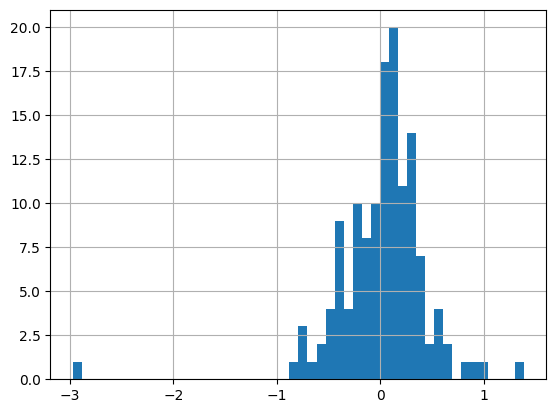

In [28]:
trades_df["profit"].hist(bins=50)

The following plot shows, that during the first year, there have been less trades. The most negativ trades was made during first half of 2023 and was shortly followed by the most profitable one.

<Axes: xlabel='start_date'>

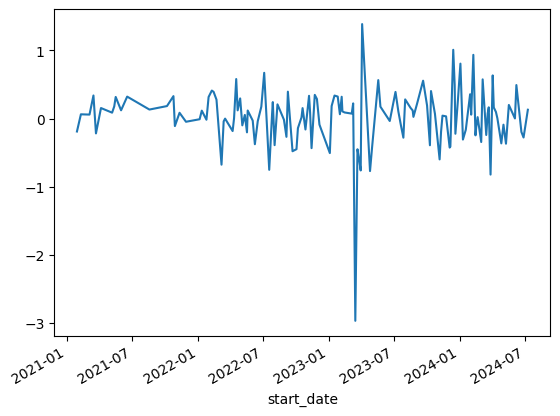

In [29]:
trades_df.set_index("start_date")["profit"].plot()

## Trade with fees

Now we run the same strategy, but add an 0.1% fee. Considering the bid-ask spread for six transactions per trade (two stocks trades and one currency trade per open/close), this fee will probably be higher. But it gives an idea of how important fees in arbitrage are, an environment where profits per trade are often relatively small.

In [30]:
transaction_fee_percent = 0.001
trades = trading_strategy(df_filtered, transaction_fee_percent)

trades_df = pd.DataFrame(trades)
trades_df["profit"].sum()

np.float64(-8.4280709456424)

The sum of all trades has dropped from 2.79 without fees to --8.43 after fees. The following overview confirms, that the mean profit per trade has turned into a loss. The strategy is no longer profitable with a 0.1% fee per trade.

In [31]:
trades_df["profit"].describe()

count    135.000000
mean      -0.062430
std        0.439293
min       -3.040032
25%       -0.260147
50%       -0.017254
75%        0.147405
max        1.306947
Name: profit, dtype: float64

The following histogram shows, that the distribution of profits stayed the same, but the mean shifted slightly to the left.

<Axes: >

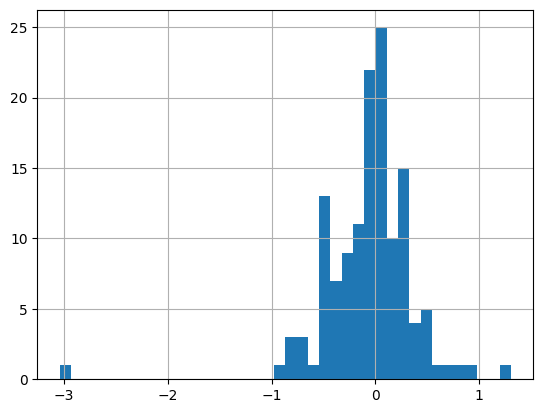

In [32]:
trades_df["profit"].hist(bins=40)